## Modelling With FBProphet

We will try to create the time-series model on our Household Power Consumption Dataset with Fbprohet Library

In [1]:
conda install -c conda-forge fbprophet 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.7.0                |             py_0         1.3 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py37hc8dfbb8_0         151 KB  conda-forge
    cftime-1.1.1.2             |   py37h03ebfcd_0         317 KB  conda-forge
    convertdate-2.1.3          |          py_1000          30 KB  conda-forge
    curl-7.69.1                |       h33f0ec9_0         137 KB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
  

## Imports

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from hdfs import InsecureClient
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import nan
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
import time


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Importing plotly failed. Interactive plots will not work.


## Read Dataset

In [3]:
client = InsecureClient('http://datalake:50070')
with client.read('/shared/ml/data/Power_Analysis/Household Power train data/household_power_consumption_hours.csv',
                 encoding = 'utf-8') as reader:
    
    df_hour_wise = pd.read_csv(reader,
                     index_col=[0],
                     date_parser= pd.to_datetime,
                     infer_datetime_format=True,
                     low_memory=False
                    )

In [4]:
df_hour_wise.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [5]:
df_hour_wise.shape

(34589, 7)

In [6]:
df_hour_wise.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
df_hour_wise.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


###  Split of Dataset

In [8]:
df_train = df_hour_wise[: -100]
df_test = df_hour_wise[-100 : ]

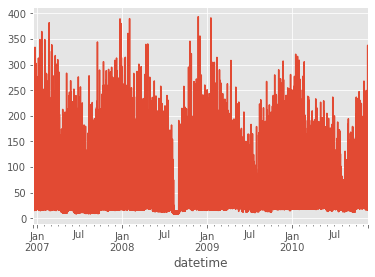

In [9]:
df_train.Global_active_power.plot()

From the above we can see some annual seasonality as well as some weekly seasonality

In [10]:
df_pr_train = pd.DataFrame()
df_pr_test = pd.DataFrame()
df_pr_train['ds'] = pd.to_datetime(df_train.index)
df_pr_train['y'] = np.log(df_train.Global_active_power.values)
df_pr_test['ds'] = pd.to_datetime(df_test.index)
df_pr_test['y'] = np.log(df_test.Global_active_power.values)

In [11]:
df_pr_train.head()

,ds,y
0,2006-12-16 17:00:00,5.024038
1,2006-12-16 18:00:00,5.384183
2,2006-12-16 19:00:00,5.318189
3,2006-12-16 20:00:00,5.278696
4,2006-12-16 21:00:00,5.211604


In [12]:
from sapdi import tracking

start = time.time()

params = {
    "growth":'linear',
    "weekly_seasonality": True,
    "daily_seasonality": True
}

# Initialize SAP DI Tracking 
run = tracking.start_run(run_collection_name='power_consumption_run')

prophet_basic = Prophet(**params)
prophet_basic.fit(df_pr_train) 

tracking.log_parameters(params) 

print('FBProphet Model Training Completed in {} seconds'.format(time.time()-start))

FBProphet Model Training Completed in 41.546021938323975 seconds


In [13]:
future= prophet_basic.make_future_dataframe(periods=100,freq='H',include_history = False )

In [14]:
future.head()

,ds
0,2010-11-22 18:00:00
1,2010-11-22 19:00:00
2,2010-11-22 20:00:00
3,2010-11-22 21:00:00
4,2010-11-22 22:00:00


In [15]:
future.shape

(100, 1)

In [16]:
# Python
start = time.time()
forecast = prophet_basic.predict(future)
print('FBProphet Model prediction Completed in {} seconds'.format(time.time()-start))

FBProphet Model prediction Completed in 2.0282480716705322 seconds


In [17]:
forecast.set_index('ds',inplace=True)

In [18]:
forecast.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2010-11-22 18:00:00,3.936914,3.526598,5.279339,3.936914,3.936914,0.456997,0.456997,0.456997,0.219062,0.219062,...,-0.078496,-0.078496,-0.078496,0.316430,0.316430,0.316430,0.0,0.0,0.0,4.393910
2010-11-22 19:00:00,3.936921,3.878988,5.622372,3.936921,3.936921,0.785660,0.785660,0.785660,0.546461,0.546461,...,-0.077454,-0.077454,-0.077454,0.316652,0.316652,0.316652,0.0,0.0,0.0,4.722580
2010-11-22 20:00:00,3.936927,3.999821,5.742367,3.936927,3.936927,0.958959,0.958959,0.958959,0.717935,0.717935,...,-0.075846,-0.075846,-0.075846,0.316870,0.316870,0.316870,0.0,0.0,0.0,4.895886
2010-11-22 21:00:00,3.936934,3.944754,5.701080,3.936934,3.936934,0.859306,0.859306,0.859306,0.615921,0.615921,...,-0.073699,-0.073699,-0.073699,0.317084,0.317084,0.317084,0.0,0.0,0.0,4.796240
2010-11-22 22:00:00,3.936941,3.619783,5.361525,3.936941,3.936941,0.541330,0.541330,0.541330,0.295079,0.295079,...,-0.071043,-0.071043,-0.071043,0.317294,0.317294,0.317294,0.0,0.0,0.0,4.478271


In [19]:
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2010-11-22 18:00:00,3.936914,3.526598,5.279339,3.936914,3.936914,0.456997,0.456997,0.456997,0.219062,0.219062,...,-0.078496,-0.078496,-0.078496,0.316430,0.316430,0.316430,0.0,0.0,0.0,4.393910
2010-11-22 19:00:00,3.936921,3.878988,5.622372,3.936921,3.936921,0.785660,0.785660,0.785660,0.546461,0.546461,...,-0.077454,-0.077454,-0.077454,0.316652,0.316652,0.316652,0.0,0.0,0.0,4.722580
2010-11-22 20:00:00,3.936927,3.999821,5.742367,3.936927,3.936927,0.958959,0.958959,0.958959,0.717935,0.717935,...,-0.075846,-0.075846,-0.075846,0.316870,0.316870,0.316870,0.0,0.0,0.0,4.895886
2010-11-22 21:00:00,3.936934,3.944754,5.701080,3.936934,3.936934,0.859306,0.859306,0.859306,0.615921,0.615921,...,-0.073699,-0.073699,-0.073699,0.317084,0.317084,0.317084,0.0,0.0,0.0,4.796240
2010-11-22 22:00:00,3.936941,3.619783,5.361525,3.936941,3.936941,0.541330,0.541330,0.541330,0.295079,0.295079,...,-0.071043,-0.071043,-0.071043,0.317294,0.317294,0.317294,0.0,0.0,0.0,4.478271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,3.937557,3.368179,5.044663,3.937557,3.937557,0.248502,0.248502,0.248502,-0.057032,-0.057032,...,-0.015816,-0.015816,-0.015816,0.321350,0.321350,0.321350,0.0,0.0,0.0,4.186060
2010-11-26 18:00:00,3.937564,3.623754,5.328300,3.937564,3.937564,0.530237,0.530237,0.530237,0.219062,0.219062,...,-0.010072,-0.010072,-0.010072,0.321246,0.321246,0.321246,0.0,0.0,0.0,4.467801
2010-11-26 19:00:00,3.937571,3.960897,5.588662,3.937571,3.937571,0.863432,0.863432,0.863432,0.546461,0.546461,...,-0.004169,-0.004169,-0.004169,0.321139,0.321139,0.321139,0.0,0.0,0.0,4.801003


In [20]:
actual_predicted_test_df = df_test.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'inner')

In [21]:
actual_predicted_test_df.shape

(100, 10)

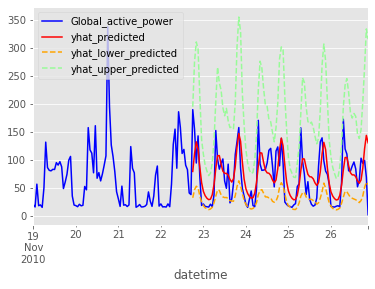

In [22]:
actual_predicted_test_df['yhat_predicted'] = np.expm1(actual_predicted_test_df.yhat)
actual_predicted_test_df['yhat_lower_predicted'] = np.expm1(actual_predicted_test_df.yhat_lower)
actual_predicted_test_df['yhat_upper_predicted'] = np.expm1(actual_predicted_test_df.yhat_upper)
ax = df_hour_wise['11/19/2010':].Global_active_power.plot(color = 'blue')
ax = actual_predicted_test_df.yhat_predicted.plot(color = 'red')
ax = actual_predicted_test_df.yhat_lower_predicted.plot(color = 'orange',linestyle = 'dashed')
ax = actual_predicted_test_df.yhat_upper_predicted.plot(color = 'palegreen',linestyle = 'dashed')
ax.legend()
plt.show()

In [23]:
actual_predicted_test_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,yhat,yhat_lower,yhat_upper,yhat_predicted,yhat_lower_predicted,yhat_upper_predicted
datetime,,,,,,,,,,,,,
2010-11-22 18:00:00,190.098,7.552,14065.11,834.4,1196.0,0.0,0.0,4.393910,3.526598,5.279339,79.956381,33.008066,195.240128
2010-11-22 19:00:00,155.370,8.266,14063.24,669.4,865.0,9.0,0.0,4.722580,3.878988,5.622372,111.458051,47.375218,275.544473
2010-11-22 20:00:00,94.952,7.960,14199.99,400.2,25.0,70.0,0.0,4.895886,3.999821,5.742367,132.738474,53.588369,310.801610
2010-11-22 21:00:00,143.322,2.882,14347.62,596.8,0.0,0.0,639.0,4.796240,3.944754,5.701080,120.054379,50.663641,298.190371
2010-11-22 22:00:00,69.912,4.214,14592.12,289.0,0.0,0.0,548.0,4.478271,3.619783,5.361525,87.082229,36.329468,212.049678


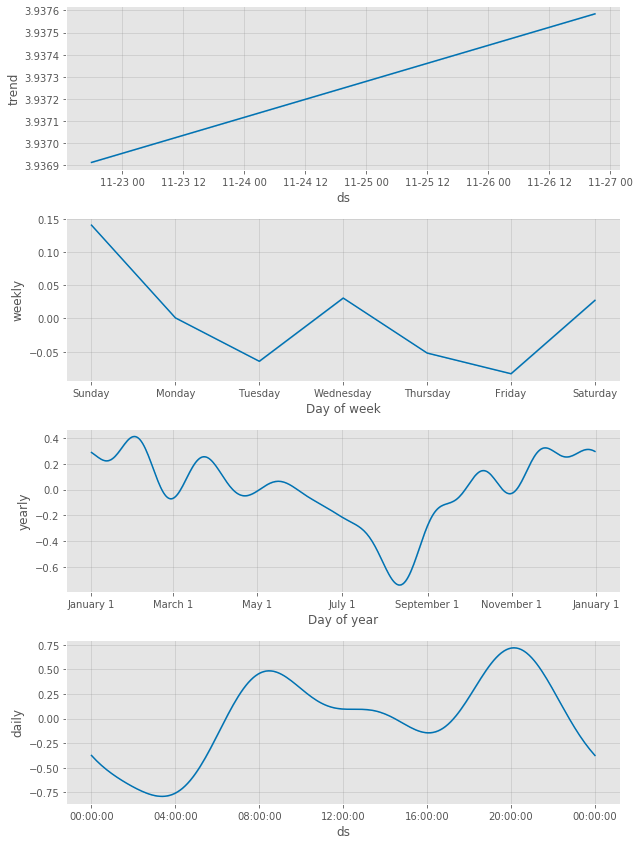

In [24]:
forecast.reset_index(level=0, inplace=True)
ax = prophet_basic.plot_components(forecast)
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error

RMSE = format(np.sqrt(mean_squared_error(actual_predicted_test_df.Global_active_power, actual_predicted_test_df.yhat_predicted)))
print('RMSE with FBProphet is {}'.format(np.sqrt(mean_squared_error(actual_predicted_test_df.Global_active_power, actual_predicted_test_df.yhat_predicted))))

RMSE with FBProphet is 35.39991275840871


In [26]:
tracking.log_metric('RMSE' , RMSE )
tracking.set_tags({
    "model" : "FBProphet"
})
tracking.end_run() 

In [27]:
# save the model
import pickle

filename = 'FBProphet_model_for_power_consumption.pkl'
pickle.dump(prophet_basic, open(filename, 'wb'))

In [28]:
import sapdi
import json

In [29]:
sc = sapdi.get_current_scenario()

In [30]:
run_data =  tracking.get_runs( scenario = sc,notebook = sapdi.scenario.Notebook.get(notebook_id="40 Training FBProphet Model.ipynb"))

In [31]:
run_json = json.loads(str(run_data))

In [32]:
df = pd.DataFrame.from_dict(run_json[0]['metrics'])

In [33]:
df.head()

,name,timestamp,value
0,RMSE,2020-04-13T09:17:40.572049Z,35.399913


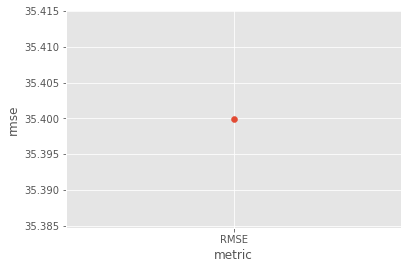

In [34]:
import matplotlib.pyplot as plt
plt.scatter(x = df.name , y = df.value )
plt.xlabel('metric')
plt.ylabel('rmse')
plt.show()